## 正态分布与平方损失

若随机变量x具有均值$\mu$和方差$\sigma^2$（标准差$\sigma$），其正态分布概率密度函数如下：
$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

In [1]:
import math, d2l
import numpy as np
import matplotlib.pyplot as plt


def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5/sigma**2 * (x - mu)**2)

In [2]:
# 可视化正态分布；
x = np.arange(-7, 7, 0.01)
x, x.shape

(array([-7.  , -6.99, -6.98, ...,  6.97,  6.98,  6.99]), (1400,))

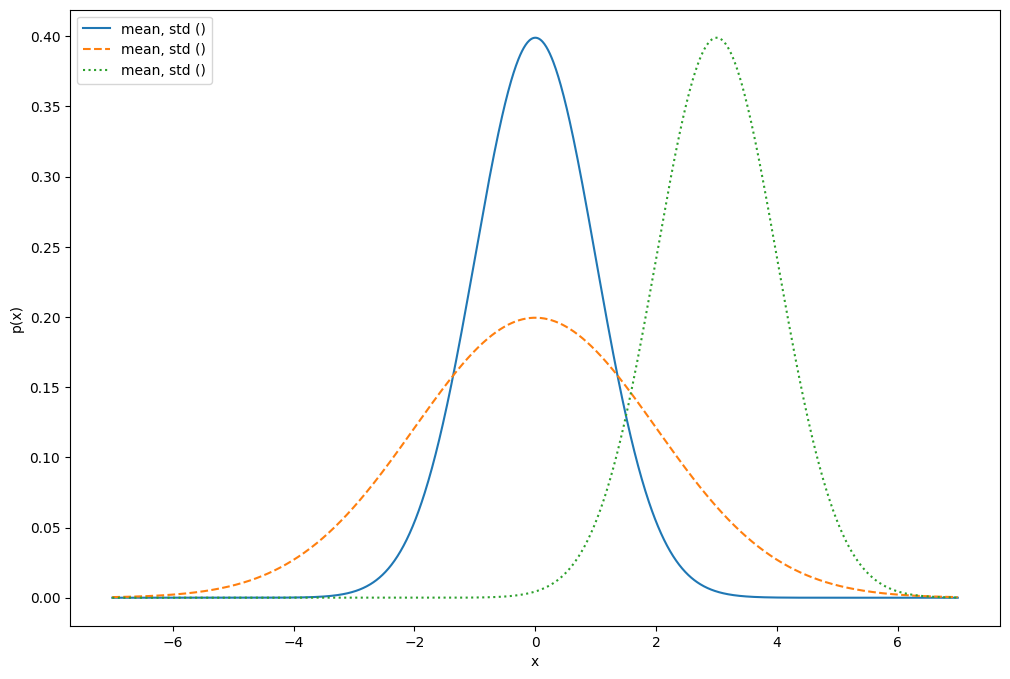

In [3]:
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, [normal(x, mu, sigma) for mu, sigma in params][0], '-', label=f"mean, std {()}".format(params[0]))
ax.plot(x, [normal(x, mu, sigma) for mu, sigma in params][1], '--', label=f"mean, std {()}".format(params[1]))
ax.plot(x, [normal(x, mu, sigma) for mu, sigma in params][2], ':', label=f"mean, std {()}".format(params[2]))
ax.set_xlabel("x")
ax.set_ylabel("p(x)")

ax.legend(loc="upper left")

## 线性回归的从零开始实现

In [4]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集
在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。

In [5]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
features, features.shape, labels, labels.shape

(tensor([[-1.6257, -0.4771],
         [ 0.7020,  0.8572],
         [ 0.1119, -1.4183],
         ...,
         [ 0.1454,  2.9390],
         [ 0.7387,  0.7130],
         [-0.2810,  0.2716]]),
 torch.Size([1000, 2]),
 tensor([[ 2.5845e+00],
         [ 2.6832e+00],
         [ 9.2360e+00],
         [ 6.8719e+00],
         [ 4.8762e+00],
         [ 9.7786e+00],
         [ 9.1918e+00],
         [ 3.3329e+00],
         [ 4.7608e+00],
         [ 3.2489e+00],
         [ 9.5772e-01],
         [ 7.4265e+00],
         [ 1.3770e+01],
         [ 3.4650e+00],
         [ 3.9952e+00],
         [ 3.8170e+00],
         [ 6.6299e+00],
         [ 2.8696e+00],
         [ 7.9740e+00],
         [ 1.1850e+01],
         [ 3.0658e+00],
         [ 6.1257e+00],
         [ 4.4464e+00],
         [ 7.8198e+00],
         [ 1.0781e+01],
         [ 5.4956e+00],
         [ 1.3463e+01],
         [-7.6181e+00],
         [ 6.4664e+00],
         [ 3.9253e+00],
         [ 8.2609e+00],
         [ 1.1119e+00],
         [ 7.4785e

In [7]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.6257, -0.4771]) 
label: tensor([2.5845])


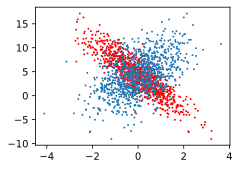

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].numpy(), labels.detach().numpy(), s=1, c="red") # 表示散点图点的大小；
d2l.plt.scatter(features[:, (0)].numpy(), labels.detach().numpy(), s=1) 

### 小批量随机读取数据集

采用**小批量随机梯度下降**，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能**打乱数据集中的样本并以小批量方式获取数据**。

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # random.shuffle()用于将一个列表中的元素打乱顺序，值得注意的是使用这个方法不会生成新的列表，只是将原列表的次序打乱。
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            # 切片，一次取一个batch_size的，不过最后的可能会超过，比如，取3个，但共有10个，3 3 3 3 最后一个3只有一个，若取3会报错；
            indices[i: min(i + batch_size, num_examples)]
        )
        # yield的函数是一个迭代器，函数返回某个值时，会停留在某个位置，返回函数值后，会在前面停留的位置继续执行，直到程序结束。
        # 返回一个随机批量的样本；
        yield features[batch_indices], labels[batch_indices]

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[-0.4880,  2.1191],
        [ 2.0013,  0.2877],
        [ 0.4587,  1.5712],
        [ 0.3730, -0.5428],
        [-0.6516,  0.2904],
        [-2.1779,  0.4510],
        [ 0.2926, -1.5483],
        [ 0.5055,  1.0029],
        [-1.5733, -0.1800],
        [-0.0032,  0.0227]]) 
 tensor([[-3.9974],
        [ 7.2134],
        [-0.2176],
        [ 6.8102],
        [ 1.9212],
        [-1.7022],
        [10.0571],
        [ 1.7892],
        [ 1.6724],
        [ 4.1068]])


### 初始化模型参数
开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数（初试的w，b）。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [11]:
# 需要对w，b计算梯度；
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [12]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数
本节使用的平方差损失函数。

In [13]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法
sgd：随机梯度下降

In [14]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035318
epoch 2, loss 0.000129
epoch 3, loss 0.000051


In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0007, 0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0010], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

### 生成数据集

In [17]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [18]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [19]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

### 读取数据集

In [20]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    # *变量名 在python中做函数形参，可以表示一个可变长度的序列，不过是tuple类型，
    # 而**也可以做形参，而且是dict类型，他俩可以同时作为函数形参（也可以只有一个），不过若含有他俩的话得把*放在前面，而**在后。
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [21]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [22]:
# next() 返回迭代器的下一个项目
next(iter(data_iter))

[tensor([[ 0.2294,  0.9208],
         [ 0.1923, -0.8465],
         [-0.8836,  0.3009],
         [ 1.5256, -1.8794],
         [ 0.0440, -0.1338],
         [ 0.8500, -1.4677],
         [ 0.2231, -0.3301],
         [-1.1527,  0.4363],
         [ 1.1267, -0.4743],
         [ 0.9412, -0.9416]]),
 tensor([[ 1.5385],
         [ 7.4601],
         [ 1.4032],
         [13.6420],
         [ 4.7390],
         [10.8992],
         [ 5.7724],
         [ 0.4240],
         [ 8.0631],
         [ 9.2909]])]

### 定义模型

In [23]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1)) 
# 2 是输入维数， 第一个指定输入特征形状；
# 1 第二个指定输出特征形状,输出特征形状为单个标量,因此为1。

### 初始化模型参数

- 在使用net之前,我们需要初始化模型参数。
- 在线性回归模型中的权重和偏置。深度学习框架通常有预定义的方法来初始化参数。
- 我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样,偏置参数将初始化为零。

In [24]:
# net[0] 神经网络的第0层；
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [25]:
# 均方误差，mean squired loss
loss = nn.MSELoss()

### 定义优化算法

In [26]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练

In [27]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000180
epoch 2, loss 0.000091
epoch 3, loss 0.000091


In [28]:
w = net[0].weight.data 
print('w的估计误差:', true_w - w.reshape(true_w.shape)) 
b = net[0].bias.data 
print('b的估计误差:', true_b - b)

w的估计误差: tensor([-9.6798e-05,  2.4557e-05])
b的估计误差: tensor([0.0003])


## Softmax回归（多分类问题）

### 图像分类数据集

In [29]:
%matplotlib inline 
import torch 
import torchvision 
from torch.utils import data 
from torchvision import transforms 
from d2l import torch as d2l 

d2l.use_svg_display() # svg格式显示图片，清晰度更高一点；

In [30]:
# 我们可以通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中
# 并除以255使得所有像素的数值均在0到1之间；
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
# train=True是训练集数据，False是测试集数据，transform=trans 图片的Tensor()格式

> Fashion-MNIST由10个类别的图像组成, 每个类别由训练数据集 (train dataset) 中的6000张图像和测试数据集(test dataset)中的1000张图像组成。因此,训练集和测试集分别包含60000和10000张图像。测试数据集不会用于训练,只用于评估模型性能

In [31]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [32]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [33]:
# 以下函数用于在数字标签索引及其文本名称之间进行转换
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                  'sandal', 'shirt', 'sneanker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [34]:
# 可视化这些样本
def show_image(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneanker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneanker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

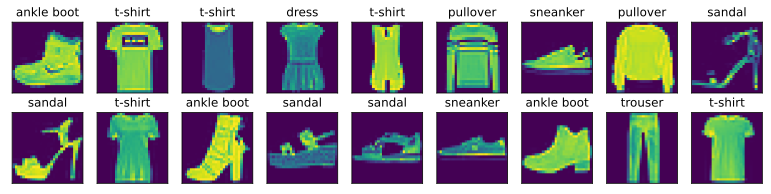

In [35]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_image(X.reshape(18, 28,28), 2, 9, titles=get_fashion_mnist_labels(y))

### 读取小批量

In [36]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [37]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{ timer.stop():.2f} sec'

'3.33 sec'

### 整合所有组件


In [38]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [39]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## Softmax回归的从零开始实现

In [40]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化参数模型

In [41]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [42]:
# test

In [43]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [44]:
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [45]:
X.sum(0), X.sum(1)

(tensor([5., 7., 9.]), tensor([ 6., 15.]))

In [46]:
# testover

In [47]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里用了广播机制；

In [48]:
# test

In [49]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0461, 0.1690, 0.4032, 0.2560, 0.1257],
         [0.2068, 0.0515, 0.4742, 0.0638, 0.2037]]),
 tensor([1.0000, 1.0000]))

In [50]:
# testover

### 定义模型

In [51]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数

In [52]:
# test
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

# 把样本识别为y真实类别的概率是多少；
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [53]:
y, y.shape, y_hat

(tensor([0, 2]),
 torch.Size([2]),
 tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]))

In [54]:
# testover

In [55]:
# 交叉熵
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [56]:
# 测试一下 交叉熵
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度

In [57]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 取每一行最大元素的下标即为预测的类别；
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [58]:
# 预测正确的个数 / 总样本数
accuracy(y_hat, y) / len(y) 

0.5

同样，对于任意数据迭代器data_iter可访问的数据集， 我们可以评估在任意模型net的精度。

In [59]:
def evaluate_accuracy(net, data_iter): 
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [60]:
# 仅累加，不重要
class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [61]:
evaluate_accuracy(net, test_iter)

0.0648

### 训练

In [62]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [63]:
# 动画展示训练过程，不重要；
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [64]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [65]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

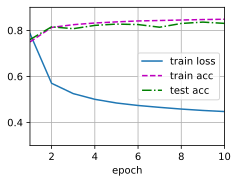

In [66]:
# 训练
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

In [67]:
def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
    X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

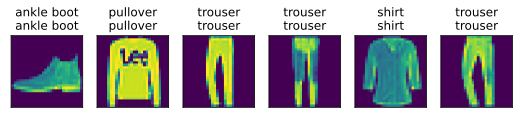

In [68]:
predict_ch3(net, test_iter)

## Softmax回归的简洁实现

In [70]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [71]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [72]:
loss = nn.CrossEntropyLoss(reduction='none')

In [73]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

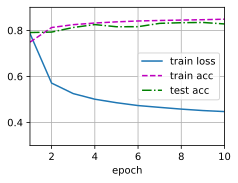

In [74]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)